# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [5]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from dateutil import parser
%matplotlib inline

In [6]:
DATA_FOLDER = '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Explanation
A quick analysis of the dataset reveals that there are some inconsistencies, and therefore the first step will require some cleaning and some transformation steps. We can identify the following problems:
- The columns have different names among different countries. For example, the Guinea dataset contains the columns: "Date,Description,Totals", whereas Liberia contains "Date,Variable,National" (the columns have the same meaning).
- The CSV files have a variable number of columns. Fortunately, this is not an issue in our case, since we are only interested in totals.
- There are many missing values. These will be treated as 0.
- Dates are given in different formats, such as '2014-08-04' or '6/16/2014'.
- Some records contain newlines. This issue is automatically handled by Pandas.
- Row descriptions are inconsistent and are provided under different names. For instance, in Guinea we can find the following variables:
    - New cases of suspects
    - New cases of probables
    - New cases of confirmed
    - Total new cases registered so far *(the sum of the previous ones)*
    
    Conversely, in Liberia we can observe:
    - New Case/s (Suspected)
    - New Case/s (Probable)
    - New case/s (confirmed) *(notice the difference between "Case" and "case")*
    
    There are other examples of these irregularities. They will be matched together.
    
### Plan
The task will be subdivided into three parts:
1. Dataset cleaning. This subtask will produce a consistent, uniform dataset.
2. Pivoting: "new cases" and "new death" will be added as new columns.
3. Aggregation: it will return the required daily averages per month.

### Remarks
Since it was not specified, we made some assumptions: by "new cases" we mean the sum of suspect, probable, and confirmed cases. 

In [53]:
# Load the dataset
country_paths = glob.glob(DATA_FOLDER + 'ebola/*/')
country_names = [os.path.basename(os.path.normpath(x)).replace('_data', '').capitalize() for x in country_paths]

In [54]:
# Country names are derived from the directory name (N.B.: Sl = Sierra Leone)
print(country_names)

['Guinea', 'Liberia', 'Sl']


In [55]:
# As explained earlier, we need to map different aliases to a standard column name
aliases = {
    'variable': 'description',
    'national': 'totals'
}

In [56]:
dfs = []
for i, path in enumerate(country_paths):
    filenames = glob.glob(path + "/*.csv")
    for f in filenames:
        df = pd.read_csv(f)
        df.columns = [c.lower() for c in df.columns] # Set all columns to lower-case
        df.rename(columns=aliases, inplace=True)
        df['country'] = country_names[i]
        df['date'] = [parser.parse(x, tzinfos={'dayfirst': True}) for x in df['date']] # Parse date
        df['totals'] = pd.to_numeric(df['totals'], errors='coerce')
        df = df.fillna(0) # Fill empty values with zeros
        dfs.append(df[['date', 'country', 'description', 'totals']]) # Extract only relevant columns
        
df = pd.concat(dfs)
df['description'] = [x.lower() for x in df['description']]
df.head()

,date,country,description,totals
0,2014-08-04,Guinea,new cases of suspects,5.0
1,2014-08-04,Guinea,new cases of probables,0.0
2,2014-08-04,Guinea,new cases of confirmed,4.0
3,2014-08-04,Guinea,total new cases registered so far,9.0
4,2014-08-04,Guinea,total cases of suspects,11.0


In [57]:
# NIC

# map descriptiond to either "new_cases" or "new_deaths"
column_keywords = {
    'new cases of suspects' : 'new_cases',
    'new cases of probables' : 'new_cases',
    'new cases of confirmed' : 'new_cases',
    'new case/s (suspected)' : 'new_cases',
    'new case/s (probable)' : 'new_cases',
    'new case/s (confirmed)' : 'new_cases',
    'new_suspected' : 'new_cases',
    'new_probable' : 'new_cases', 
    'new_confirmed' : 'new_cases',
    
    'new deaths registered today' : 'new_deaths', 
    'new deaths registered' : 'new_deaths', 
    'newly reported deaths' : 'new_deaths',
    'etc_new_deaths' : 'new_deaths'
}
# dfcopy = df.copy()
# dfcopy.description = df.description.apply(lambda desc: column_keywords[desc] if desc in column_keywords else np.NaN)
# dfcopy.dropna(how='any', inplace = True) # drop any row that has at least one nan
# dfcopy = dfcopy.reset_index() # is didn't have unique indices
# print(dfcopy.shape) 
# dfcopy.head()


# or, without pivoting, add directly the two columns "new_cases" and "new_deaths" and then group by day
dfcopy1 = df.copy()
# drop the rows wich does not correspond neither to "new_cases" nor to "new_deaths"
dfcopy1 = dfcopy1[dfcopy1.description.isin(column_keywords)]
# get a series representing, for each row to which keyword ()"new_cases" or "new_deaths") it correspond
keywords = dfcopy1.description.apply(lambda desc: column_keywords[desc])
# add a new column for the new cases and write down the totals if "description" correspond to "new_cases"
dfcopy1["new_cases"] = dfcopy1.totals*(keywords == "new_cases") #if it is not a "new_cases" then put 0
dfcopy1["new_deaths"] = dfcopy1.totals*(keywords == "new_deaths") #if it is not a "new_deaths" then put 0

print(dfcopy1.shape)
dfcopy1.head(20)


(900, 6)


,date,country,description,totals,new_cases,new_deaths
0,2014-08-04,Guinea,new cases of suspects,5.0,5.0,0.0
1,2014-08-04,Guinea,new cases of probables,0.0,0.0,0.0
2,2014-08-04,Guinea,new cases of confirmed,4.0,4.0,0.0
8,2014-08-04,Guinea,new deaths registered today,2.0,0.0,2.0
0,2014-08-26,Guinea,new cases of suspects,18.0,18.0,0.0
1,2014-08-26,Guinea,new cases of probables,0.0,0.0,0.0
2,2014-08-26,Guinea,new cases of confirmed,10.0,10.0,0.0
9,2014-08-26,Guinea,new deaths registered,5.0,0.0,5.0
0,2014-08-27,Guinea,new cases of suspects,12.0,12.0,0.0
1,2014-08-27,Guinea,new cases of probables,0.0,0.0,0.0


In [58]:
# NIC
dfcopy1.drop(['totals', 'description'], inplace=True, axis=1)
print(dfcopy1.groupby(['date', 'country']).sum().shape)
dfcopy1 = dfcopy1.groupby(['date', 'country']).sum().reset_index()

# then the same:
# Group by country, year, month, and aggregate with the mean value. This produces the daily average per country/year/month.
dfcopy1 = dfcopy1.groupby([dfcopy1.country, dfcopy1.date.dt.year, dfcopy1.date.dt.month]).mean()
dfcopy1.index.names = ['country', 'year', 'month']
dfcopy1 = dfcopy1.reset_index().sort_values(ascending=[True, True, True], by=['country', 'year', 'month'])
dfcopy1.head()

(225, 2)


,country,year,month,new_cases,new_deaths
0,Guinea,2014,8,25.800000,3.400000
1,Guinea,2014,9,19.625000,3.562500
2,Guinea,2014,10,34.000000,15.000000
3,Liberia,2014,6,5.714286,2.000000
4,Liberia,2014,7,8.545455,4.272727


In [59]:
# Now we extract the relevant variables and we map them to a standard name (new_cases and new_deaths)
column_keywords = {
    'new_cases': ['new cases of suspects', 'new cases of probables', 'new cases of confirmed', 'new case/s (suspected)',
                 'new case/s (probable)', 'new case/s (confirmed)',  'new_suspected', 'new_probable', 'new_confirmed'],
    'new_deaths': ['new deaths registered today', 'new deaths registered', 'newly reported deaths',
                  'etc_new_deaths']
}

desc_map = []
for k, v in column_keywords.items():
    for alias in v:
        desc_map.append((k, alias))
desc_map = pd.DataFrame(desc_map, columns=['type', 'description'])
df = df.merge(desc_map, on='description', how='inner')
df = df.drop('description', axis=1)

In [60]:
# This is much better
df.head(20)

,date,country,totals,type
0,2014-08-04,Guinea,5.0,new_cases
1,2014-08-26,Guinea,18.0,new_cases
2,2014-08-27,Guinea,12.0,new_cases
3,2014-08-30,Guinea,15.0,new_cases
4,2014-08-31,Guinea,9.0,new_cases
5,2014-09-02,Guinea,11.0,new_cases
6,2014-09-04,Guinea,13.0,new_cases
7,2014-09-07,Guinea,5.0,new_cases
8,2014-09-08,Guinea,5.0,new_cases
9,2014-09-09,Guinea,9.0,new_cases


In [61]:
# The dataframe is pivoted so as to transform new_cases and new_deaths types to columns
# Furthermore, equivalent types are aggregated with a sum (e.g. suspected + probable + confirmed)
pivoted = df.pivot_table(index=['date', 'country'], columns='type', values='totals', aggfunc='sum')
pivoted.columns.name = None
df = pivoted.reset_index()

In [62]:
# Some records from Liberia
df[df.country == 'Liberia'].head()

,date,country,new_cases,new_deaths
0,2014-06-16,Liberia,4.0,2.0
1,2014-06-17,Liberia,2.0,0.0
2,2014-06-22,Liberia,10.0,4.0
3,2014-06-24,Liberia,6.0,4.0
4,2014-06-25,Liberia,7.0,3.0


In [63]:
# Group by country, year, month, and aggregate with the mean value. This produces the daily average per country/year/month.
df_ = df.groupby([df.country, df.date.dt.year, df.date.dt.month]).mean()
df_.index.names = ['country', 'year', 'month']
df_.reset_index().sort_values(ascending=[True, True, True], by=['country', 'year', 'month'])

,country,year,month,new_cases,new_deaths
0,Guinea,2014,8,25.800000,3.400000
1,Guinea,2014,9,19.625000,3.562500
2,Guinea,2014,10,34.000000,15.000000
3,Liberia,2014,6,5.714286,2.000000
4,Liberia,2014,7,8.545455,4.272727
5,Liberia,2014,8,37.222222,23.222222
6,Liberia,2014,9,63.833333,36.041667
7,Liberia,2014,10,45.560000,28.040000
8,Liberia,2014,11,26.466667,13.466667
9,Liberia,2014,12,5178.555556,0.000000


In [64]:
# NIC
# the solution is the same
df_.reset_index().sort_values(ascending=[True, True, True], by=['country', 'year', 'month']).equals(dfcopy1)

True

### Final observations
The number of new cases in Liberia, in December 2014, seems too high. However, a manual inspection revealed that this figure is reflected in the original dataset.

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

## Explanation
By looking at the various files we observe that:
- The format of the spreadsheet is consistent throughout the files.
- The columns have no title, therefore we named them respectively "TAXON" and "COUNT".  
- Since the first column of the files is alphbetically sorted, it is easy to notice that, within the same file, it seems this column is unique. We verified this ipothesis after loading the files but then discovered that, instead, the first column of the DataFrame concatenating all the files is not unique. Therefore, since this column could not be used as unique index we decided to use a MultiIndex with both the column "TAXON" and "BARCODE".

### Plan
The task has been subdivided into four parts:
1. We loaded one file per time while adding a new column to bind the loaded rows to the file identifier, e.g. to the dataset loaded from MID1.xls we added a column "BARCODE" with value "MID1". 
2. Join: the column added at the previous step made it easy to join the obtained DataFrame with the metadata table.
3. Fill NaN values with the tag "unknown".
4. Set "TAXON" and "BARCODE" as index.

In [65]:
path = DATA_FOLDER + "microbiome"
metadata = glob.glob(path + "/metadata.xls")
filenames = glob.glob(path + "/MID*.xls")

rnaData = []
for i, file in enumerate(filenames):
    currData = pd.read_excel(file, header=None, names=["TAXON", "COUNT"])
    currData["BARCODE"] = "MID"+str(i+1) # Add a column value to do the join
    rnaData.append(currData)

result = pd.concat(rnaData)
result.head()

,TAXON,COUNT,BARCODE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1


In [66]:
# Perform an inner join on BARCODE, so as to match the metadata with the actual content
metadata = pd.read_excel(metadata[0])
result = pd.merge(result, metadata, how="inner", on="BARCODE")
result.head()

,TAXON,COUNT,BARCODE,GROUP,SAMPLE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1,EXTRACTION CONTROL,NaN
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1,EXTRACTION CONTROL,NaN
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1,EXTRACTION CONTROL,NaN
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1,EXTRACTION CONTROL,NaN
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1,EXTRACTION CONTROL,NaN


In [67]:
# Replace missing values (NaNs) with "unknown"
result = result.fillna("unknown")
# Make sure that there are no NaNs
print(pd.isnull(result).sum()) 

TAXON      0
COUNT      0
BARCODE    0
GROUP      0
SAMPLE     0
dtype: int64


In [68]:
# set an index that is unique (the combination of TAXON and BARCODE is suitable)
result.set_index(["TAXON","BARCODE"], inplace=True)
print(result.index.is_unique) # Check uniqueness

# Show a sample of the transformed dataset
result.sample(10)

True


,,COUNT,GROUP,SAMPLE
TAXON,BARCODE,,,
"Archaea ""Euryarchaeota"" Halobacteria Halobacteriales Halobacteriaceae Halosimplex",MID7,2,Control 1,stool
"Bacteria ""Proteobacteria"" Betaproteobacteria Nitrosomonadales Nitrosomonadaceae Nitrosospira",MID1,1,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",MID6,7,NEC 1,stool
"Bacteria ""Thermotogae"" Thermotogae Thermotogales Thermotogaceae Geotoga",MID8,4,NEC 2,stool
"Bacteria ""Bacteroidetes"" ""Sphingobacteria"" ""Sphingobacteriales"" ""Chitinophagaceae"" Sediminibacterium",MID7,7,Control 1,stool
"Bacteria ""Firmicutes"" ""Clostridia"" Clostridiales Clostridiaceae Geosporobacter",MID2,7,NEC 1,tissue
"Bacteria ""Proteobacteria"" Epsilonproteobacteria Campylobacterales Campylobacteraceae Arcobacter",MID7,780,Control 1,stool
"Bacteria ""Firmicutes"" ""Clostridia"" Clostridiales Veillonellaceae Anaeroarcus",MID8,4,NEC 2,stool
"Bacteria ""Proteobacteria"" Gammaproteobacteria Xanthomonadales Xanthomonadaceae Aquimonas",MID7,1,Control 1,stool


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [36]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Explanation
The dataset consists of a single .xls file, which contains 1309 entries of passengers with 14 attributes. The attributes are transformed as follows:
- If an attribute takes on a limited and fixed number of values, the type is set to Categorical.
- If an attribute states a true/false condition , the type is set to boolean.
- NaNs or missing values are not replaced in the first instance, but handled according to the question. 

## Plan
Steps and details are discussed below for each question.

### Question 1
Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`.

In [7]:
# Display numeric columns
titanic = pd.read_excel(DATA_FOLDER + '/titanic.xls', sheetname='titanic')
numeric_titanic = titanic.select_dtypes(include=[np.number])
numeric_titanic.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'body'], dtype='object')

Every numeric column has limited range.

In [8]:
# We show the range only for numeric columns
def value_range(series):
    return series.max() - series.min()
numeric_titanic.agg(['min', 'max', value_range])

,pclass,survived,age,sibsp,parch,fare,body
min,1,0,0.1667,0,0,0.0000,1.0
max,3,1,80.0000,8,9,512.3292,328.0
value_range,2,1,79.8333,8,9,512.3292,327.0


The following attributes are transformed:
- `pclass` can be set to Categorical (1/2/3)
- `sex` can be set to Categorical (male/female)
- `embarked` can be set to Categorical (C/Q/S)
- `survived` can be set to boolean

In [9]:
titanic['pclass'] = titanic['pclass'].astype('category')
titanic['sex'] = titanic['sex'].astype('category')
titanic['embarked'] = titanic['embarked'].astype('category')
titanic['survived'] = titanic['survived'].astype('bool')
print(titanic.dtypes)
titanic.head()

pclass       category
survived         bool
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Question 2
Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

#### Steps
For each of the listed attributes, the frequency of its values is shown on a histogram.
#### Outcome
The charts show that: 
- The number of passengers in third class is higher than the number of passengers in first and second class together.
- Most of the passengers embarked in Southampton, where the journey of the ship started.
- The number of male passengers was almost two times the number of the female ones.
- The passengers were relatively young.

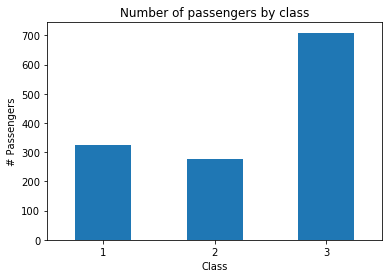

In [10]:
travel_class = titanic['pclass'].value_counts(sort = False)
ax = travel_class.plot.bar(title = 'Number of passengers by class', rot=0)
ax.set_xlabel('Class')
ax.set_ylabel('# Passengers')
plt.show()

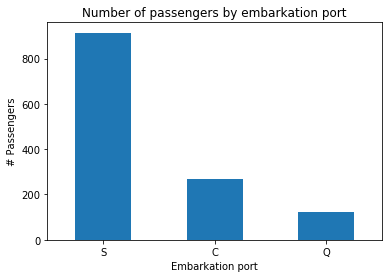

In [11]:
embark_port = titanic['embarked'].value_counts()
ax = embark_port.plot.bar(title = 'Number of passengers by embarkation port', rot=0)
ax.set_xlabel('Embarkation port')
ax.set_ylabel('# Passengers')
plt.show()

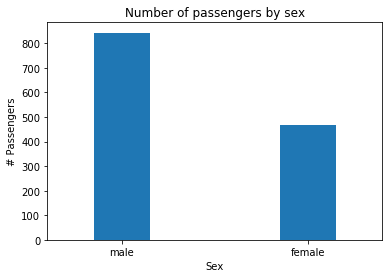

In [12]:
sex = titanic['sex'].value_counts()
ax = sex.plot.bar(title = 'Number of passengers by sex', width = 0.3, rot=0)
ax.set_xlabel('Sex')
ax.set_ylabel('# Passengers')
plt.show()

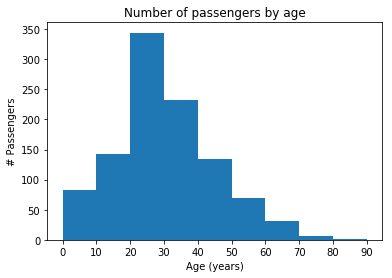

In [13]:
decades = [0,10,20,30,40,50,60,70,80,90]
ax = titanic['age'].plot.hist(bins=decades , title='Number of passengers by age')
ax.set_xticks(decades)
ax.set_xlabel('Age (years)')
ax.set_ylabel('# Passengers')
plt.show()

### Question 3
Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

#### Steps
- The number of entries with missing cabin floor is large, therefore they have been dropped from the table.
- The cabin floor is indicated by the first letter of the cabin.
- For each floor, the number of entries is counted and divided by the total number of entries.


#### Outcome
According to the chart, a large number of passengers was in the upper floors (B and C). However, this result is not consistent with the previous charts, which indicate that most passengers were in third class (lower floors). The dataset includes only a little information about the cabins of the third-class passengers.

           %
C  31.864407
B  22.033898
D  15.593220
E  13.898305
A   7.457627
F   7.118644
G   1.694915
T   0.338983


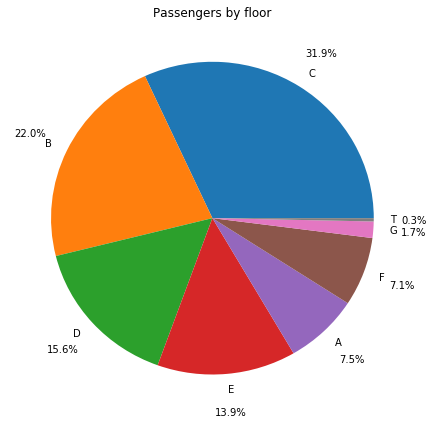

In [35]:
# The first character corresponds to the cabin floor. Unknown record are discarded.
cab_floor = pd.Series(list(map(lambda e: e[0], titanic['cabin'].dropna())))
cab_floor = cab_floor.value_counts()
percent = cab_floor / sum(cab_floor)
percent = pd.DataFrame({'%':percent*100})
print(percent)
plt.figure(figsize=(6,6))
ax = cab_floor.plot.pie(title = 'Passengers by floor', autopct="%1.1f%%", pctdistance=1.25)
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### Question 4
For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

#### Steps
- Entries have been grouped by travel class.
- For each travel class, the number of survived passengers is divided by the number of passengers.


#### Outcome
The chart shows that the travel class significantly affected the chances of surviving. It can be stated that the social class was a large discriminatory factor in that period. 

pclass
1    0.619195
2    0.429603
3    0.255289
Name: survived, dtype: float64


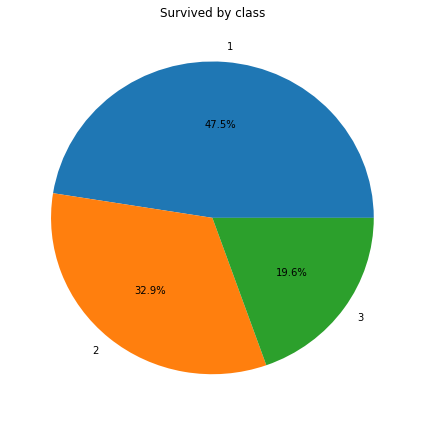

In [78]:
pclass_grouped = titanic.groupby(titanic.pclass)['survived']
percent = pclass_grouped.sum() / pclass_grouped.count() 
print(percent)
plt.figure(figsize=(6,6))
ax = percent.plot.pie(title = 'Survived by class', autopct="%1.1f%%")
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### Question 5
Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

#### Steps
- Entries have been grouped by travel class and sex.
- For each combination of travel class and sex, the number of survived passengers is divided by the number of passengers.


#### Outcome
The chart shows that female passengers had higher chances of surviving within their travel class. Probably, they had priority during the evacuation process. The result is consistent with the previous chart, showing how the travel class was influential as well.

pclass  sex   
1       female    0.965278
        male      0.340782
2       female    0.886792
        male      0.146199
3       female    0.490741
        male      0.152130
Name: survived, dtype: float64


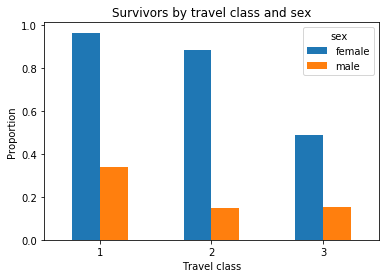

In [79]:
pclass_grouped = titanic.groupby(['pclass', 'sex'])['survived']
percent = pclass_grouped.sum() / pclass_grouped.count()
print(percent)
ax = percent.unstack().plot.bar(title='Survivors by travel class and sex', rot=0)
ax.set_xlabel('Travel class')
ax.set_ylabel('Proportion')
plt.show()

### Question 6
Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

#### Steps
- The median is calculated over the age to find a value that divides equally the entries.
- Entries are split in two groups, according to whether the age is lower or equal/higher than the median.
- Entries have been grouped by age category, travel class and sex.
- For each combination of age category, travel class and sex, the number of survived passengers is divided by the number of passengers.
- Each combination of age category, class and sex is a unique index of the table.


#### Outcome
Half of the passenger were less than 28 years old, and they had higher chances of surviving. There may be different reasons, i.e. they could swim and resist better in the cold water of the ocean, or they could have had priority during the evacuation process (such as the underage passengers). The table is consistent with the previous charts, showing that sex and travel class influenced the chances of surviving as well.

In [80]:
people = titanic[titanic.age.notnull()].copy()
# Use the median to divide the age into two equally populated categories
split = np.median(people['age'])
print('Split point:', split, 'years')
people['age_category'] = (people['age'] >= split).astype('int')
people_grouped = people.groupby(['age_category', 'pclass', 'sex'])['survived']
percentage = people_grouped.sum() / people_grouped.count()
result = pd.DataFrame(percentage)
print('Unique index:', result.index.is_unique)
result

Split point: 28.0 years
Unique index: True


survived
age_category pclass sex             
0            1      female  0.950000
                    male    0.535714
             2      female  0.901961
                    male    0.235294
             3      female  0.528302
                    male    0.194313
1            1      female  0.967742
                    male    0.308943
             2      female  0.884615
                    male    0.077778
             3      female  0.347826
                    male    0.130435